In [1]:
"""Use Nick's PPO trained policy to perform inference on whether there is a pedestrian or not"""

import argparse
from datetime import datetime
import gym
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import PyQt5

import ray
try:
    from ray.rllib.agents.agent import get_agent_class
except ImportError:
    from ray.rllib.agents.registry import get_agent_class
from ray.tune.registry import register_env

from flow.core.util import emission_to_csv
from flow.utils.registry import make_create_env
from flow.utils.rllib import get_flow_params
from flow.utils.rllib import get_rllib_config
from flow.utils.rllib import get_rllib_pkl

from examples.rllib.multiagent_exps.test_predictor.pedestrian_policy_1 import create_env, create_agent
from examples.rllib.multiagent_exps.bayesian_0_env import make_flow_params as bayesian_0_flow_params

EXAMPLE_USAGE = """
example usage:
    python ./visualizer_rllib.py /ray_results/experiment_dir/result_dir 1
Here the arguments are:
1 - the path to the simulation results
2 - the number of the checkpoint
"""

/home/thankyou-always/anaconda3/envs/flow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/thankyou-always/anaconda3/envs/flow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/thankyou-always/anaconda3/envs/flow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/thankyou-always/ana

In [2]:
%matplotlib inline

Policy takes in an observation of length 22 (10 + max_num_objects * 3)

observation[4:10] = ped_param

I want the set to posterior probabilities: $$Pr(\text{ped_in_grid_i} | action), \forall i = 1, \ldots, 6$$

$Pr(\text{ped_in_grid_i} | \text{action}) = \frac{Pr(\text{action} | \text{ped_in_i}) Pr(\text{ped_in_i})}{Pr(\text{action})}$

$\Pr(action) = \sum_{i=1}^6 \Pr(action | ped\text{_}in\text{_}i) \Pr(ped\text{_}in\text{_}i)$


Compute Pr(action | ped_in_i) by taking

1. actual state e.g. s = [a, b, c, d, [0], e, _, _, _], where I only care about the ith grid (suppose there is no ped in the ith grid)

2. actual state with flipped pedestrian at grid i, i.e
s_flipped = [a, b, c, d, [1], e, _, _, _]

Input these two into the policy to get PDFs:

If $s[i] == 0,$ ped_PDF = $\pi(s\text{_}flipped)$ and no_ped_PDF = $\pi(s)$. Pr(action | ped_in_i) = $\frac{ped\text{_}PDF}{ped\text{_}PDF + ped\text{_}no\text{_}PDF}$

If $s[i] == 1,$ ped_PDF = $\pi(s)$ and no_ped_PDF = $\pi(s\text{_}flipped)$. Pr(action | ped_in_i) = $\frac{ped\text{_}PDF}{ped\text{_}PDF + ped\text{_}no\text{_}PDF}$

and do the usual normalization thing to get Pr(action | ped_in_i)

In [50]:
def run_env(env, agent, config, flow_params):
    """Run the simulation and control the rl car using the trained policy. 
    
    observation[4:10] = ped_param
    
    The six binary grids are at indices 4 to 9 inclusive
    """
    # set up relevant policy and env
    if config.get('multiagent', {}).get('policies', None):
        multiagent = True
        rets = {}
        # map the agent id to its policy
        policy_map_fn = config['multiagent']['policy_mapping_fn'].func
        for key in config['multiagent']['policies'].keys():
            rets[key] = []
    else:
        multiagent = False
        rets = []

    if config['model']['use_lstm']:
        use_lstm = True
        if multiagent:
            state_init = {}
            # map the agent id to its policy
            policy_map_fn = config['multiagent']['policy_mapping_fn'].func
            size = config['model']['lstm_cell_size']
            for key in config['multiagent']['policies'].keys():
                state_init[key] = [np.zeros(size, np.float32),
                                   np.zeros(size, np.float32)]
        else:
            state_init = [
                np.zeros(config['model']['lstm_cell_size'], np.float32),
                np.zeros(config['model']['lstm_cell_size'], np.float32)
            ]
    else:
        use_lstm = False

    env.restart_simulation(
        sim_params=flow_params['sim'], render=flow_params['sim'].render)

    
    # Define variables to collect probability data
    # TODO(KL) HARD CODED is_ped_visible is the 5th item in the state vector

    ped_idx = [4, 5, 6, 7, 8, 9]
    
    # Pr(action \ ped_in_grid_i)
    probs_action_given_ped = []
    probs_action_given_no_ped = []

    # updated priors list
    probs_ped_given_action_updated_priors = []
    probs_no_ped_given_action_updated_priors = []

    # fixed priors list
    probs_ped_given_action_fixed_priors = []
    probs_no_ped_given_action_fixed_priors = []

    # updated Pr(ped), Pr(no_ped)        
    updated_prior_prob_ped = 0.5
    updated_prior_prob_no_ped = 0.5

    # fixed Pr(ped), Pr(no_ped)   
    fixed_prior_prob_ped = 0.5
    fixed_prior_prob_no_ped = 0.5

    visible_pedestrian = {i : [] for i in range(1,7)}

    for i in range(args.num_rollouts):
        state = env.reset()
        # divide by 5 to get "time" in the simulation
        for _ in range(1000):
            vehicles = env.unwrapped.k.vehicle
            pedestrian = env.unwrapped.k.pedestrian

            if multiagent:
                action, logits = {}, {}
                for agent_id in state.keys():
                    if use_lstm:
                        action[agent_id], state_init[agent_id], logits = \
                            agent.compute_action(state[agent_id], 
                                                    state=state_init[agent_id],
                                                    policy_id=policy_map_fn(agent_id))
                    else:
                        # get the array of length 6 for the rl car's POV
                        curr_ped_states = state[agent_id][ped_idx]
                        
                        for idx, val in enumerate(curr_ped_states, 1):
                            visible_pedestrian[idx].append(val)
                        
                        flipped_ped = 1 if curr_ped_states[0] == 0 else 0
                        
                        ped_flipped_state = np.copy(state[agent_id])
                        ped_flipped_state[ped_idx] = flipped_ped

                        action[agent_id], _, logit_actual = agent.compute_action(
                            state[agent_id], policy_id=policy_map_fn(agent_id), full_fetch=True)
                            
                        _, _, logit_flipped = agent.compute_action(
                            ped_flipped_state, policy_id=policy_map_fn(agent_id), full_fetch=True)

                        mu_ped, ln_sigma_ped = logit_actual['behaviour_logits']
                        mu_no_ped, ln_sigma_no_ped = logit_flipped['behaviour_logits']

                        sigma_ped = np.exp(ln_sigma_ped)
                        sigma_no_ped = np.exp(ln_sigma_no_ped)

                        action_ = action[agent_id][0]

                        # dict of probs for updated and fixed priors
                        probs_fixed = pr_ped_given_action(action_, mu_ped, sigma_ped, mu_no_ped, sigma_no_ped, fixed_prior_prob_ped, fixed_prior=True)
                        probs_updated = pr_ped_given_action(action_, mu_ped, sigma_ped, mu_no_ped, sigma_no_ped, updated_prior_prob_ped, fixed_prior=False)

                        probs_action_given_ped.append(probs_fixed["pr_a_given_ped"])
                        probs_action_given_no_ped.append(probs_fixed["pr_a_given_no_ped"])
                        
                        # Fixed priors: Pr(ped | action), Pr(no_ped | action)
                        probs_ped_given_action_fixed_priors.append(probs_fixed["pr_ped_given_action"])
                        probs_no_ped_given_action_fixed_priors.append(probs_fixed["pr_no_ped_given_action"])
                        fixed_prior_prob_ped = probs_fixed["prior"]

                        # Updated priors: Pr(ped | action), Pr(no_ped | action)
                        probs_ped_given_action_updated_priors.append(probs_updated["pr_ped_given_action"])
                        probs_no_ped_given_action_updated_priors.append(probs_updated["pr_no_ped_given_action"])
                        updated_prior_prob_ped = probs_updated["prior"] 

            else:
                action = agent.compute_action(state)
            state, reward, done, _ = env.step(action)

            if multiagent and done['__all__']:
                print(_,1)
                break
            if not multiagent and done:
                print(_,1)

                break    
            state, reward, done, _ = env.step(action)   

        visible_ped_lsts = [visible_pedestrian[i] for i in range(1, 7)]
        legends = [f'ped in grid {i}' for i in range(1, 7)]

        plot_lines(visible_ped_lsts, legends)
        plot_2_lines(probs_ped_given_action_updated_priors, probs_no_ped_given_action_updated_priors, ['Pr(ped | action) using updated priors', 'Pr(no_ped | action) using updated priors'], viewable_ped=visible_pedestrian[4])
        plot_2_lines(probs_ped_given_action_fixed_priors, probs_no_ped_given_action_fixed_priors, ['Pr(ped | action) using fixed priors of Pr(ped) = 0.5', 'Pr(no_ped | action) using fixed priors of Pr(ped) = 0.5'], viewable_ped=visible_pedestrian[5])
        plot_2_lines(probs_action_given_ped, probs_action_given_no_ped, ['Pr(action | ped)', 'Pr(action | no_ped)'], viewable_ped=visible_pedestrian[6])

        

In [51]:
def pr_ped_given_action(action, mu_ped, s_ped, mu_no_ped, s_no_ped, prior, fixed_prior=True):
    """
    @Params
    mu_ped, s_ped: mean, sd pair from the policy receiving an input state where there is a visible pedestrian 
    mu_no_ped, s_no_ped: mean, sd pair from the policy receiving an input state where there is no visible pedestrian 

    action: the vehicle's acceleration as dictated by the policy
    prior: Pr(ped)
    fixed_prior: Boolean telling us whether to 'update' the prior Pr(ped) using Pr(ped | action) or not

    @Returns
    
    probs, a dict containing:
    1. Pr(action | ped)
    2. Pr(action | no_ped)
    3. Pr(ped | action)
    4. Pr(no_ped | action)
    5. Pr(ped) for the next computation of Pr(ped|action)
    
    3, 4, 5 are calculated subject to the fixed_prior parameter
    """
    probs = {}
    
    # Compute 1, 2: Pr(action | ped), Pr(action | no_ped)
    unnormed_pr_action_given_ped = accel_pdf(mu_ped, s_ped, action)
    unnormed_pr_action_given_no_ped = accel_pdf(mu_no_ped, s_no_ped, action)
    
    pr_a_given_ped = unnormed_pr_action_given_ped / (unnormed_pr_action_given_ped + unnormed_pr_action_given_no_ped)
    pr_a_given_no_ped = 1 - pr_a_given_ped
    
    probs["pr_a_given_ped"] = pr_a_given_ped
    probs["pr_a_given_no_ped"] = pr_a_given_no_ped
    
    # Compute 3, 4: Pr(ped | action), Pr(no_ped | action)
    # Apply Bayes' rule
    pr_ped_given_action = (pr_a_given_ped * prior) / ((pr_a_given_ped * prior)  + (pr_a_given_no_ped * (1 - prior)))
    pr_no_ped_given_action = (pr_a_given_no_ped * (1 - prior)) / ((pr_a_given_ped * prior)  + (pr_a_given_no_ped * (1 - prior)))
    probs["pr_ped_given_action"] = pr_ped_given_action
    probs["pr_no_ped_given_action"] = pr_no_ped_given_action
                    
    if fixed_prior:
        probs["prior"] = prior
    else:
        probs["prior"] = probs["pr_ped_given_action"]
    return probs
    

def accel_pdf(mu, sigma, actual):
    """Return pdf evaluated at actual acceleration"""
    coeff = 1 / np.sqrt(2 * np.pi * (sigma**2))
    exp = -0.5 * ((actual - mu) / sigma)**2
    return coeff * np.exp(exp)

def run_transfer(args):
    # run transfer on the bayesian 1 env first
    bayesian_0_params = bayesian_0_flow_params(pedestrians=True, render=True)
#     import ipdb; ipdb.set_trace()
    env, env_name = create_env(args, bayesian_0_params)
    agent, config = create_agent(args, flow_params=bayesian_0_params)
    run_env(env, agent, config, bayesian_0_params)

def plot_2_lines(y1, y2, legend, viewable_ped=False):
    x = np.arange(len(y1))
    plt.plot(x, y1)
    plt.plot(x, y2)
    if viewable_ped:
        plt.plot(x, viewable_ped)
    plt.legend(legend, bbox_to_anchor=(0.5, 1.05), loc=3, borderaxespad=0.)
   
    plt.draw()
    plt.pause(0.001)
    
def plot_lines(y_val_lsts, legends):
    assert len(y_val_lsts) == len(legends)
    x = np.arange(len(y_val_lsts[0]))
    for y_vals in y_val_lsts:
        plt.plot(x, y_vals)
    plt.legend(legends, bbox_to_anchor=(0.5, 1.05), loc=3, borderaxespad=0.)
    plt.draw()
    plt.pause(0.001)

In [52]:
def create_parser():
    """Create the parser to capture CLI arguments."""
    parser = argparse.ArgumentParser(
        formatter_class=argparse.RawDescriptionHelpFormatter,
        description='[Flow] Evaluates a reinforcement learning agent '
                    'given a checkpoint.',
        epilog=EXAMPLE_USAGE)

    # required input parameters
    parser.add_argument(
        'result_dir', type=str, help='Directory containing results')
    parser.add_argument('checkpoint_num', type=str, help='Checkpoint number.')

    # optional input parameters
    parser.add_argument(
        '--run',
        type=str,
        help='The algorithm or model to train. This may refer to '
             'the name of a built-on algorithm (e.g. RLLib\'s DQN '
             'or PPO), or a user-defined trainable function or '
             'class registered in the tune registry. '
             'Required for results trained with flow-0.2.0 and before.')
    parser.add_argument(
        '--num_rollouts',
        type=int,
        default=1,
        help='The number of rollouts to visualize.')
    parser.add_argument(
        '--gen_emission',
        action='store_true',
        help='Specifies whether to generate an emission file from the '
             'simulation')
    parser.add_argument(
        '--evaluate',
        action='store_true',
        help='Specifies whether to use the \'evaluate\' reward '
             'for the environment.')
    parser.add_argument(
        '--render_mode',
        type=str,
        default='sumo_gui',
        help='Pick the render mode. Options include sumo_web3d, '
             'rgbd and sumo_gui')
    parser.add_argument(
        '--save_render',
        action='store_true',
        help='Saves a rendered video to a file. NOTE: Overrides render_mode '
             'with pyglet rendering.')
    parser.add_argument(
        '--horizon',
        type=int,
        help='Specifies the horizon.')
    
    return parser

2020-04-01 00:23:37,348	INFO node.py:498 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-04-01_00-23-37_348681_4374/logs.
2020-04-01 00:23:37,463	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:41556 to respond...
2020-04-01 00:23:37,583	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:29049 to respond...
2020-04-01 00:23:37,585	INFO services.py:809 -- Starting Redis shard with 3.33 GB max memory.
2020-04-01 00:23:37,628	INFO node.py:512 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-04-01_00-23-37_348681_4374/logs.
2020-04-01 00:23:37,630	INFO services.py:1475 -- Starting the Plasma object store with 4.99 GB memory using /dev/shm.


NOTE: With render mode sumo_gui, an extra instance of the SUMO GUI will display before the GUI for visualizing the result. Click the green Play arrow to continue.
(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian1Env-v0
True
NOTE: With render mode sumo_gui, an extra instance of the SUMO GUI will display before the GUI for visualizing the result. Click the green Play arrow to continue.
(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian1Env-v0
True


2020-04-01 00:23:39,935	WARNING ppo.py:143 -- FYI: By default, the value function will not share layers with the policy model ('vf_share_layers': False).


(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian1Env-v0
True


2020-04-01 00:23:41,055	INFO rollout_worker.py:319 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/home/thankyou-always/anaconda3/envs/flow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
2020-04-01 00:23:41,922	INFO rollout_worker.py:742 -- Built policy map: {'av': <ray.rllib.policy.tf_policy_template.PPOTFPolicy object at 0x7fcf7c3cc080>}
2020-04-01 00:23:41,922	INFO rollout_worker.py:743 -- Built preprocessor map: {'av': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fcf7c3ccf28>}
2020-04-01 00:23:41,922	INFO rollout_worker.py:356 -- Built filter map: {'av': <ray.rllib.utils.filter.NoFilter object at 0x7fcf7c3cc4e0>}
2020-04-01 00:23:41,925	WARNING util.py:47 -- Install gputil for GPU system monitoring.


{'rl_0': {}} 1


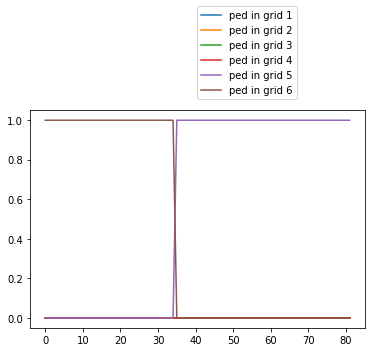

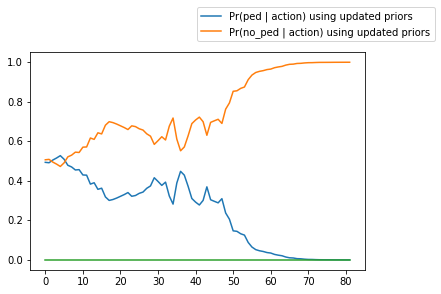

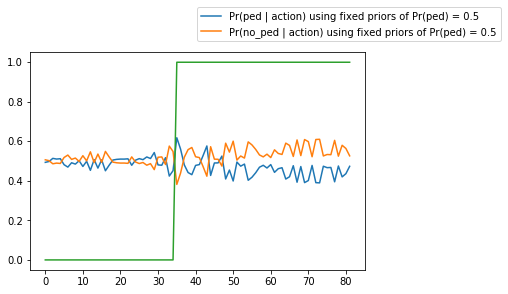

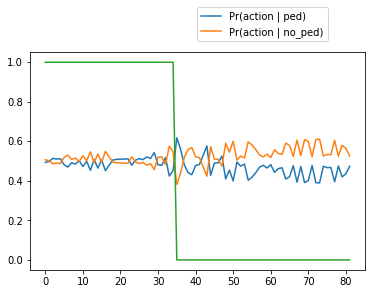

In [53]:
parser = create_parser()
args = parser.parse_args(["./PPO_Bayesian_1_250iter_1e-4lr_sumo_approach", "100"])
ray.shutdown()
ray.init(num_cpus=1)
run_transfer(args)

In [7]:
pr_ped_given_action(.6538469, 0.14252673, 2.4491935, 0.14200129, 2.5765653, 0.5100277175584501, False)

{'pr_a_given_ped': 0.512156995603998,
 'pr_a_given_no_ped': 0.48784300439600203,
 'pr_ped_given_action': 0.5221739005549169,
 'pr_no_ped_given_action': 0.47782609944508314,
 'prior': 0.5221739005549169}

In [19]:
b = np.array([11,22, 3, 4, 5, 6, 7])
c = [1, 2, 3]
b[c]

array([22,  3,  4])

In [20]:
for idx, val in enumerate(b, 1):
    print(idx, val)

1 11
2 22
3 3
4 4
5 5
6 6
7 7
